In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
data = pd.read_csv("path_to_csv").astype('float32')
data.head()

0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.639  0.640  0.641  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   

   0.642  0.643  0.644  0.645  0.646  0.647  0.648  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 785 columns]

In [3]:
width, height, channel = 28, 28, 1

In [4]:
X = data.iloc[:,1:].values
X = X.reshape((372450, width, height))
np.random.shuffle(X)
X.shape

(372450, 28, 28)

In [5]:
X = (X - 127.5) / 127.5

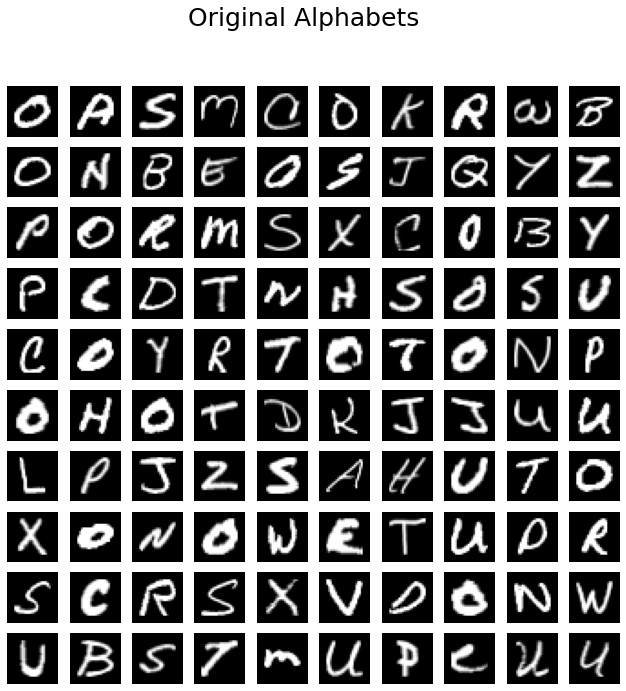

In [6]:
def show_data(X, title=""):
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in X:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height, width)), cmap='gray')
        plt.axis('off')
        i+=1
        if i>100: break

    plt.suptitle(title, fontsize = 25)
    plt.show()
    
show_data(X, title="Original Alphabets")

In [7]:
gen_optimizer = Adam(0.0001, 0.5)
disc_optimizer = Adam(0.0002, 0.5)
noise_dim = 100

In [8]:
def buildGenerator():
    model = Sequential()

    model.add(Dense(1024, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Dense(6272, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Reshape((7, 7, 128)))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(channel, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return model

In [9]:
generator = buildGenerator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_2 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_2 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)        

In [10]:
def buildDiscriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(width, height, channel)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model

In [11]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               819456    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)              

In [12]:
noise = Input(shape=(noise_dim,))
fake_data = generator(noise)
discriminator.trainable = False
output = discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [13]:
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         6595073   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1026305   
Total params: 7,621,378
Trainable params: 6,580,353
Non-trainable params: 1,041,025
_________________________________________________________________


In [14]:
fixed_noise = np.random.normal(0, 1, size=(100, noise_dim))

In [15]:
def show_generated_alphabets(title, epoch):
    imgs = generator.predict(fixed_noise)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height,width)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [16]:
epochs = 81
batch_size = 128
steps_per_epoch = len(X)//batch_size

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  0
discriminator loss:  0.572481
generator loss:  1.0587292
--------------------------------------------------------------------------------


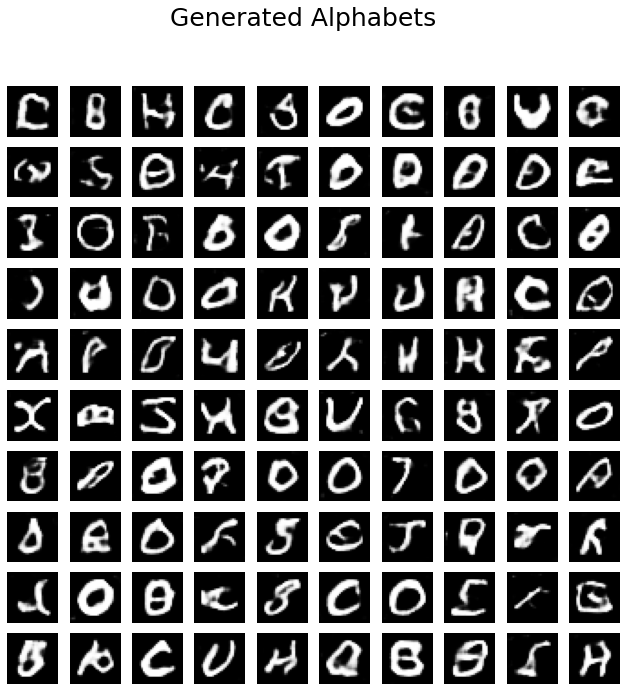

epoch:  1
discriminator loss:  0.5637933
generator loss:  0.9944166
--------------------------------------------------------------------------------
epoch:  2
discriminator loss:  0.53306395
generator loss:  0.96873623
--------------------------------------------------------------------------------
epoch:  3
discriminator loss:  0.54479754
generator loss:  1.2008169
--------------------------------------------------------------------------------
epoch:  4
discriminator loss:  0.53779685
generator loss:  0.99165887
--------------------------------------------------------------------------------
epoch:  5
discriminator loss:  0.47601038
generator loss:  1.6498551
--------------------------------------------------------------------------------


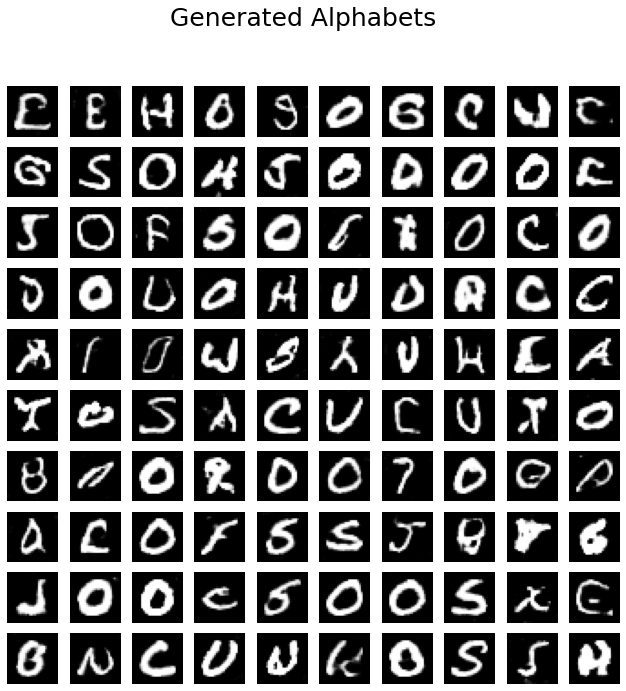

epoch:  6
discriminator loss:  0.47725043
generator loss:  1.2812803
--------------------------------------------------------------------------------
epoch:  7
discriminator loss:  0.50707984
generator loss:  1.7873851
--------------------------------------------------------------------------------
epoch:  8
discriminator loss:  0.49923196
generator loss:  1.99457
--------------------------------------------------------------------------------
epoch:  9
discriminator loss:  0.50849104
generator loss:  1.6184648
--------------------------------------------------------------------------------
epoch:  10
discriminator loss:  0.5089592
generator loss:  0.8753452
--------------------------------------------------------------------------------


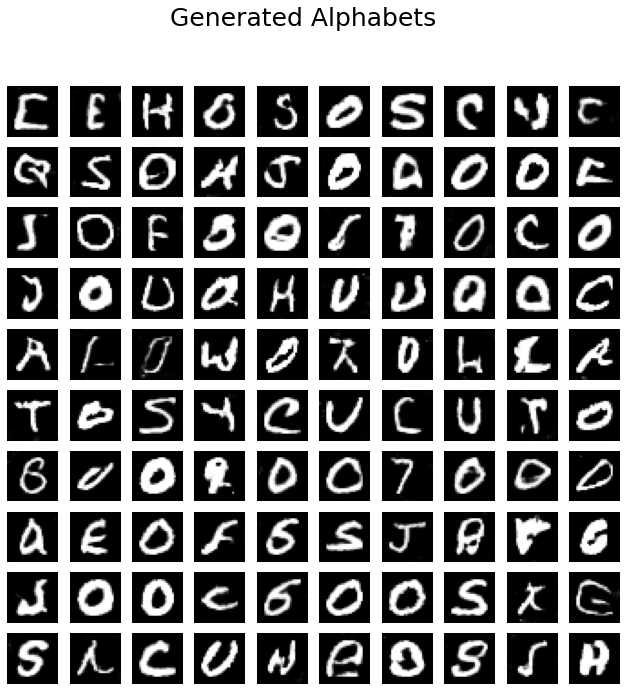

epoch:  11
discriminator loss:  0.470208
generator loss:  1.3915064
--------------------------------------------------------------------------------
epoch:  12
discriminator loss:  0.52066505
generator loss:  1.0824465
--------------------------------------------------------------------------------
epoch:  13
discriminator loss:  0.4586846
generator loss:  1.9256625
--------------------------------------------------------------------------------
epoch:  14
discriminator loss:  0.4623451
generator loss:  1.3284451
--------------------------------------------------------------------------------
epoch:  15
discriminator loss:  0.6065821
generator loss:  2.4834569
--------------------------------------------------------------------------------


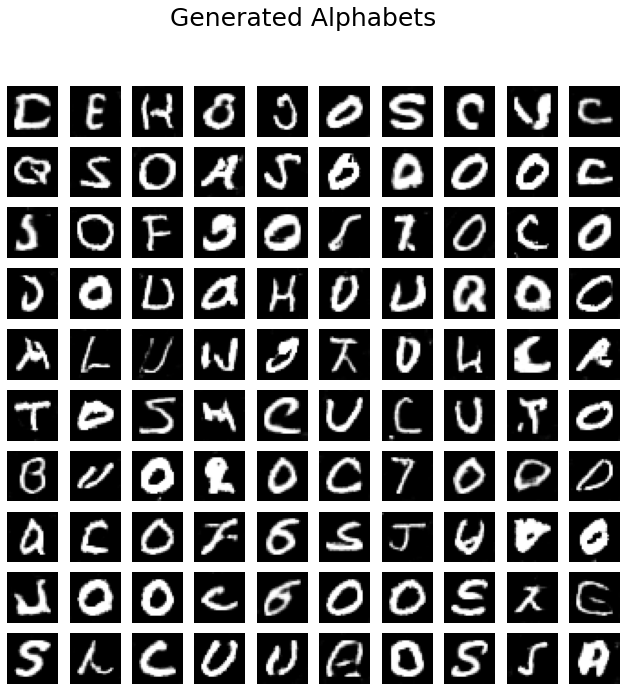

epoch:  16
discriminator loss:  0.46506828
generator loss:  1.8300344
--------------------------------------------------------------------------------
epoch:  17
discriminator loss:  0.44517875
generator loss:  1.4829233
--------------------------------------------------------------------------------
epoch:  18
discriminator loss:  0.473799
generator loss:  1.4845515
--------------------------------------------------------------------------------
epoch:  19
discriminator loss:  0.4422358
generator loss:  1.5938312
--------------------------------------------------------------------------------
epoch:  20
discriminator loss:  0.42836267
generator loss:  1.8174062
--------------------------------------------------------------------------------


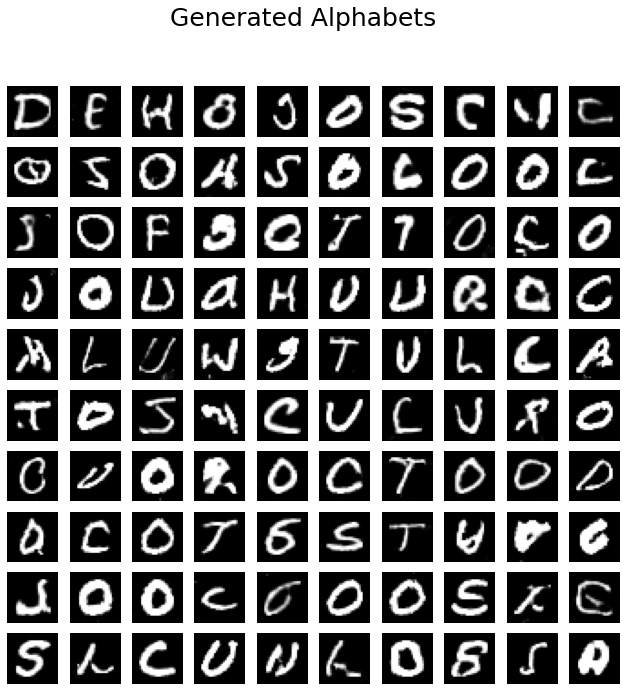

epoch:  21
discriminator loss:  0.4892192
generator loss:  1.2223585
--------------------------------------------------------------------------------
epoch:  22
discriminator loss:  0.45351192
generator loss:  1.6627557
--------------------------------------------------------------------------------
epoch:  23
discriminator loss:  0.44454336
generator loss:  2.041011
--------------------------------------------------------------------------------
epoch:  24
discriminator loss:  0.47030148
generator loss:  2.36254
--------------------------------------------------------------------------------
epoch:  25
discriminator loss:  0.43860033
generator loss:  1.9006858
--------------------------------------------------------------------------------


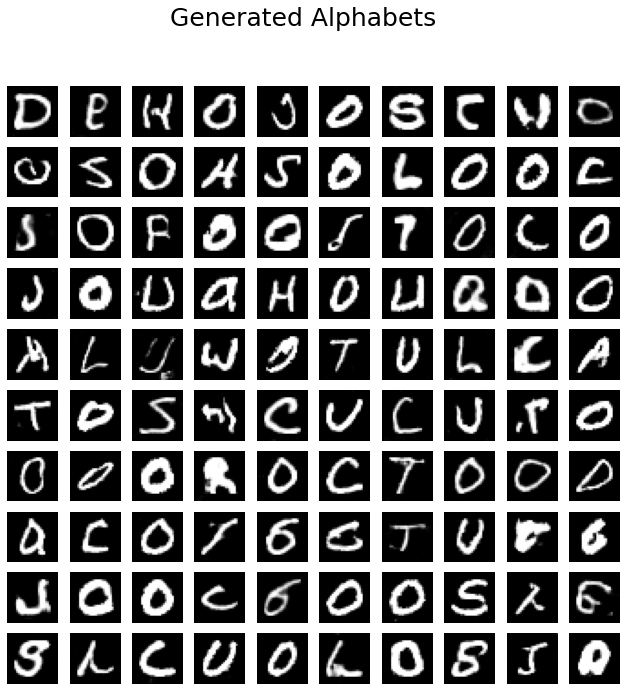

epoch:  26
discriminator loss:  0.49194452
generator loss:  1.1011182
--------------------------------------------------------------------------------
epoch:  27
discriminator loss:  0.44367567
generator loss:  1.9878626
--------------------------------------------------------------------------------
epoch:  28
discriminator loss:  0.43824595
generator loss:  1.5114181
--------------------------------------------------------------------------------
epoch:  29
discriminator loss:  0.45979714
generator loss:  2.755713
--------------------------------------------------------------------------------
epoch:  30
discriminator loss:  0.42507488
generator loss:  1.8952079
--------------------------------------------------------------------------------


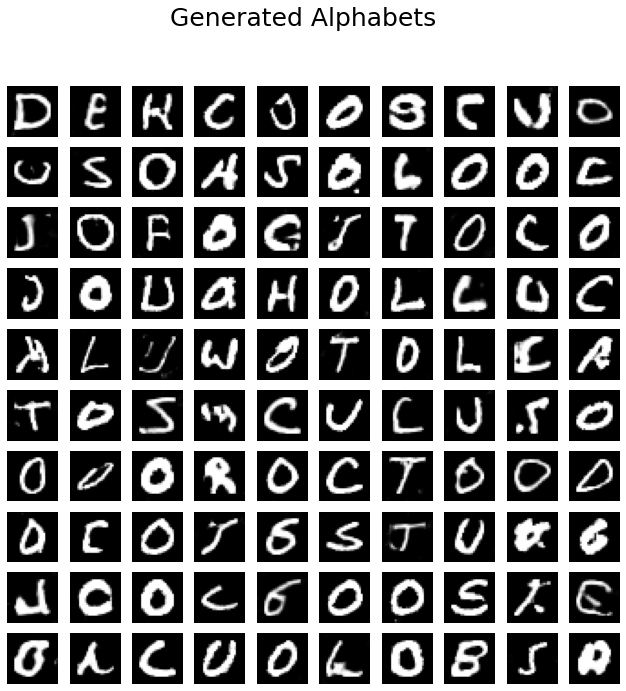

epoch:  31
discriminator loss:  0.45459056
generator loss:  2.1383085
--------------------------------------------------------------------------------
epoch:  32
discriminator loss:  0.48960972
generator loss:  1.3803307
--------------------------------------------------------------------------------
epoch:  33
discriminator loss:  0.46117082
generator loss:  1.728544
--------------------------------------------------------------------------------
epoch:  34
discriminator loss:  0.41464248
generator loss:  1.7918847
--------------------------------------------------------------------------------
epoch:  35
discriminator loss:  0.4632367
generator loss:  2.0187654
--------------------------------------------------------------------------------


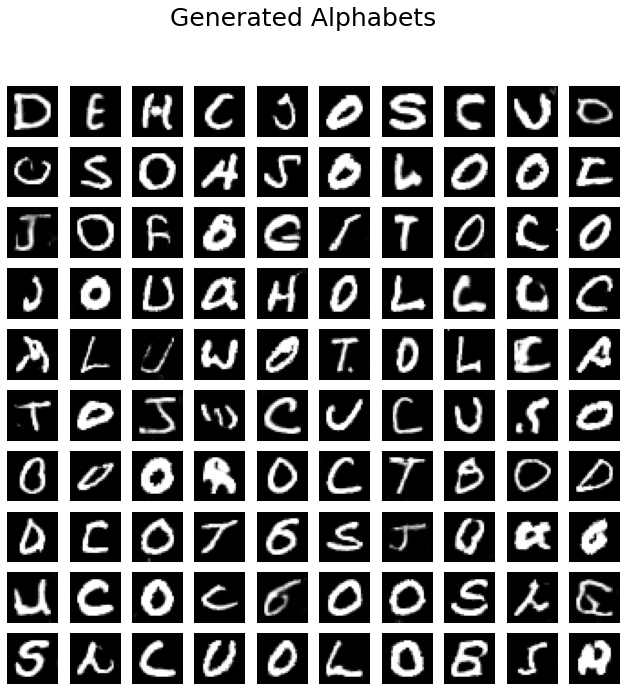

epoch:  36
discriminator loss:  0.4247272
generator loss:  2.032438
--------------------------------------------------------------------------------
epoch:  37
discriminator loss:  0.43437696
generator loss:  1.6370329
--------------------------------------------------------------------------------
epoch:  38
discriminator loss:  0.46026325
generator loss:  1.5260866
--------------------------------------------------------------------------------
epoch:  39
discriminator loss:  0.4247083
generator loss:  1.5755546
--------------------------------------------------------------------------------
epoch:  40
discriminator loss:  0.41605875
generator loss:  1.7875416
--------------------------------------------------------------------------------


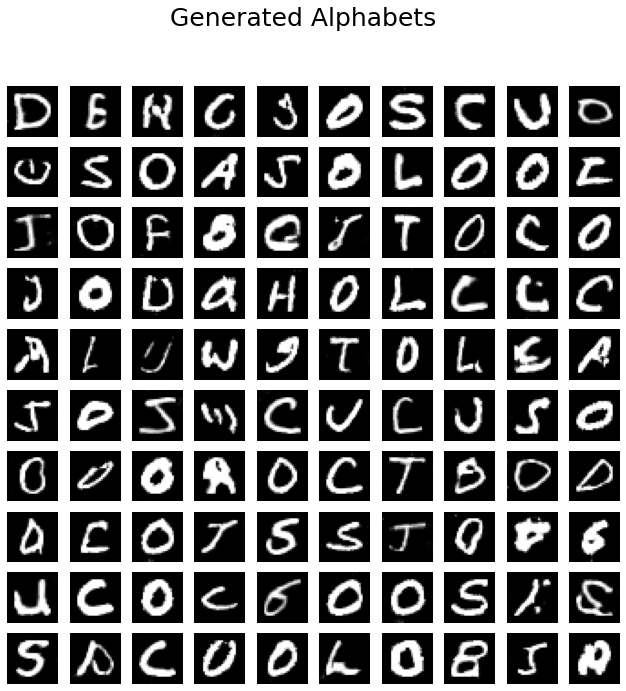

epoch:  41
discriminator loss:  0.44561583
generator loss:  2.341252
--------------------------------------------------------------------------------
epoch:  42
discriminator loss:  0.43056712
generator loss:  1.5043474
--------------------------------------------------------------------------------
epoch:  43
discriminator loss:  0.46258777
generator loss:  1.2162284
--------------------------------------------------------------------------------
epoch:  44
discriminator loss:  0.44544187
generator loss:  1.6010154
--------------------------------------------------------------------------------
epoch:  45
discriminator loss:  0.45327666
generator loss:  2.0584066
--------------------------------------------------------------------------------


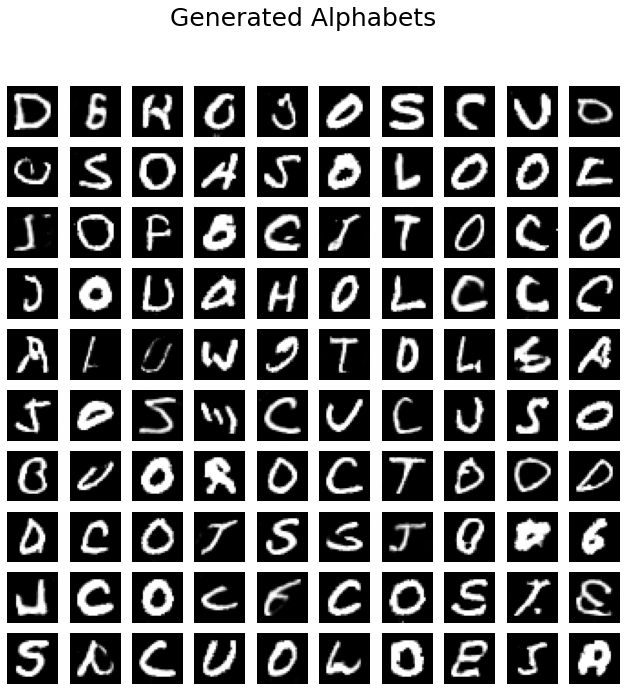

epoch:  46
discriminator loss:  0.4659357
generator loss:  1.1893228
--------------------------------------------------------------------------------
epoch:  47
discriminator loss:  0.47674498
generator loss:  1.583786
--------------------------------------------------------------------------------
epoch:  48
discriminator loss:  0.46776566
generator loss:  1.6486557
--------------------------------------------------------------------------------
epoch:  49
discriminator loss:  0.4526898
generator loss:  2.5269737
--------------------------------------------------------------------------------
epoch:  50
discriminator loss:  0.42235202
generator loss:  2.0270634
--------------------------------------------------------------------------------


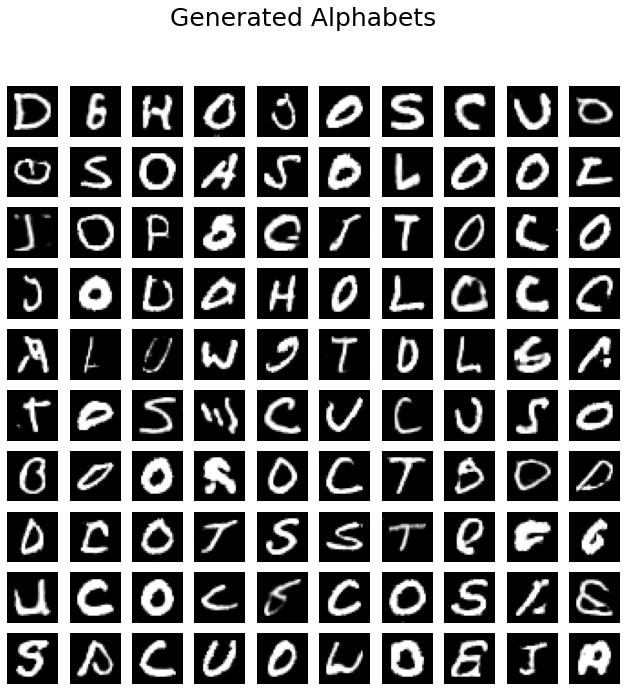

epoch:  51
discriminator loss:  0.44201288
generator loss:  1.9185537
--------------------------------------------------------------------------------
epoch:  52
discriminator loss:  0.45117506
generator loss:  1.5729592
--------------------------------------------------------------------------------
epoch:  53
discriminator loss:  0.41627988
generator loss:  1.9489411
--------------------------------------------------------------------------------
epoch:  54
discriminator loss:  0.44240844
generator loss:  1.4735372
--------------------------------------------------------------------------------
epoch:  55
discriminator loss:  0.4177947
generator loss:  1.8483304
--------------------------------------------------------------------------------


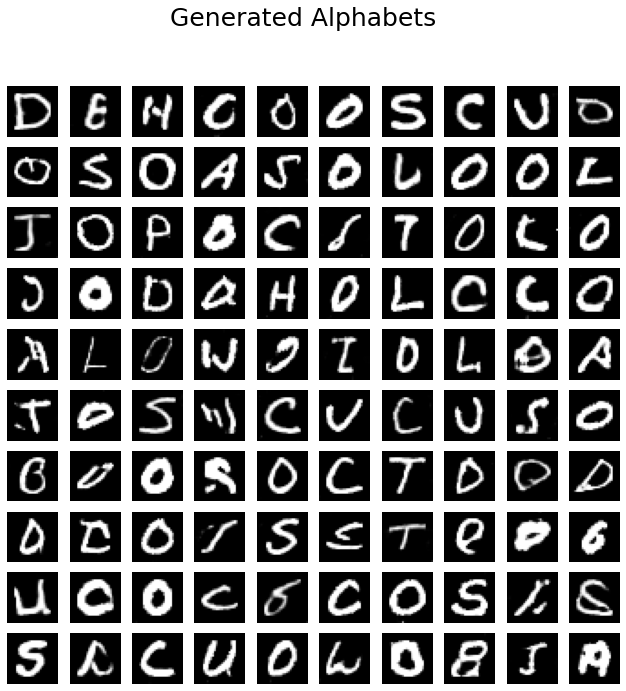

epoch:  56
discriminator loss:  0.42896146
generator loss:  1.9821537
--------------------------------------------------------------------------------
epoch:  57
discriminator loss:  0.48969656
generator loss:  1.0833149
--------------------------------------------------------------------------------
epoch:  58
discriminator loss:  0.4695288
generator loss:  1.6743921
--------------------------------------------------------------------------------
epoch:  59
discriminator loss:  0.44273704
generator loss:  1.8037376
--------------------------------------------------------------------------------
epoch:  60
discriminator loss:  0.44723707
generator loss:  2.0496337
--------------------------------------------------------------------------------


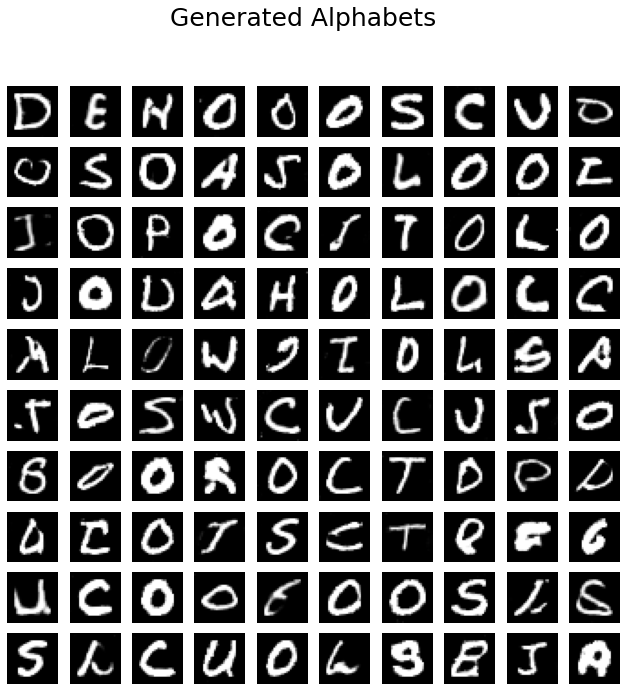

epoch:  61
discriminator loss:  0.4519731
generator loss:  2.1527777
--------------------------------------------------------------------------------
epoch:  62
discriminator loss:  0.42169908
generator loss:  1.7980227
--------------------------------------------------------------------------------
epoch:  63
discriminator loss:  0.45585826
generator loss:  1.5380231
--------------------------------------------------------------------------------
epoch:  64
discriminator loss:  0.43587846
generator loss:  1.6954175
--------------------------------------------------------------------------------
epoch:  65
discriminator loss:  0.4398159
generator loss:  2.2059011
--------------------------------------------------------------------------------


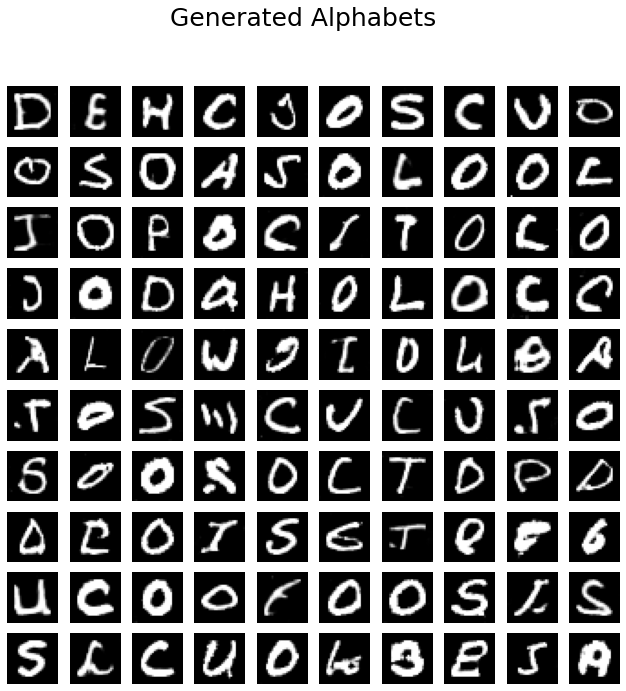

epoch:  66
discriminator loss:  0.49518266
generator loss:  1.1881365
--------------------------------------------------------------------------------
epoch:  67
discriminator loss:  0.43042576
generator loss:  1.7529804
--------------------------------------------------------------------------------
epoch:  68
discriminator loss:  0.50255895
generator loss:  2.3011088
--------------------------------------------------------------------------------
epoch:  69
discriminator loss:  0.45502558
generator loss:  2.169242
--------------------------------------------------------------------------------
epoch:  70
discriminator loss:  0.4358959
generator loss:  1.5832181
--------------------------------------------------------------------------------


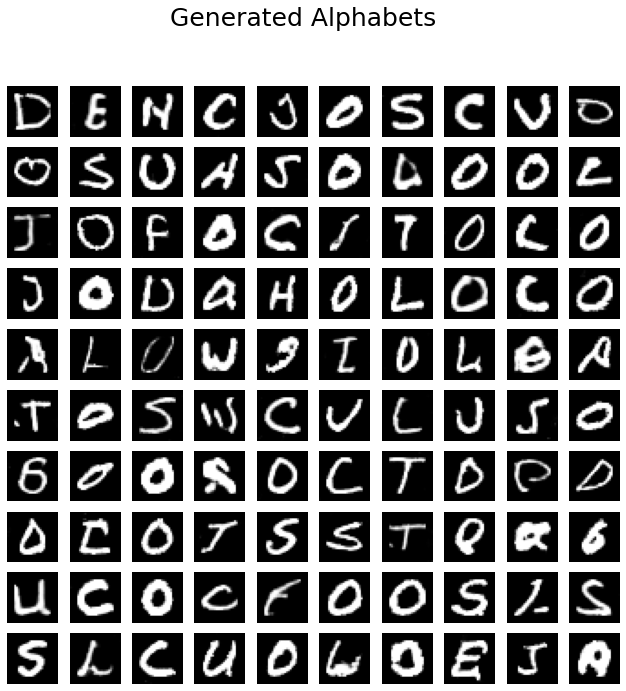

epoch:  71
discriminator loss:  0.41473255
generator loss:  1.8107326
--------------------------------------------------------------------------------
epoch:  72
discriminator loss:  0.41582245
generator loss:  1.611773
--------------------------------------------------------------------------------
epoch:  73
discriminator loss:  0.5059549
generator loss:  2.7574806
--------------------------------------------------------------------------------
epoch:  74
discriminator loss:  0.42789274
generator loss:  1.7067255
--------------------------------------------------------------------------------
epoch:  75
discriminator loss:  0.44792914
generator loss:  2.0501142
--------------------------------------------------------------------------------


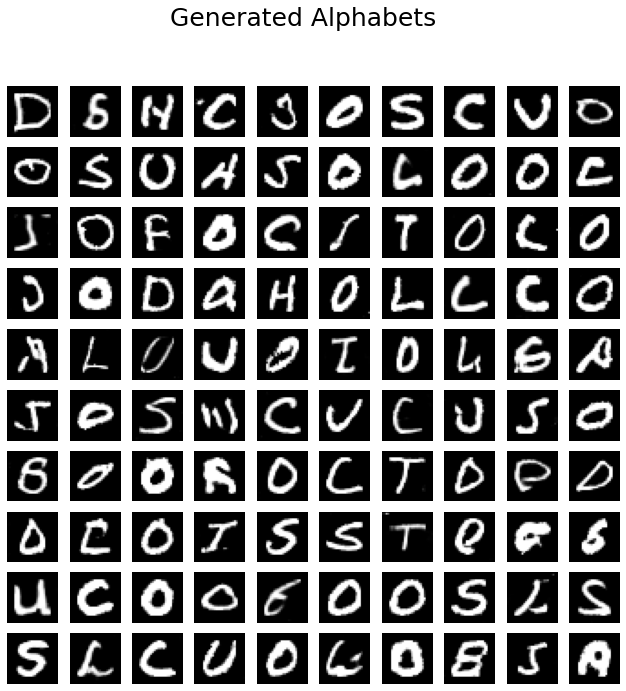

epoch:  76
discriminator loss:  0.43228313
generator loss:  1.5916882
--------------------------------------------------------------------------------
epoch:  77
discriminator loss:  0.43331683
generator loss:  1.5097495
--------------------------------------------------------------------------------
epoch:  78
discriminator loss:  0.4316811
generator loss:  2.083325
--------------------------------------------------------------------------------
epoch:  79
discriminator loss:  0.43479246
generator loss:  2.0226502
--------------------------------------------------------------------------------
epoch:  80
discriminator loss:  0.4160504
generator loss:  1.7825463
--------------------------------------------------------------------------------


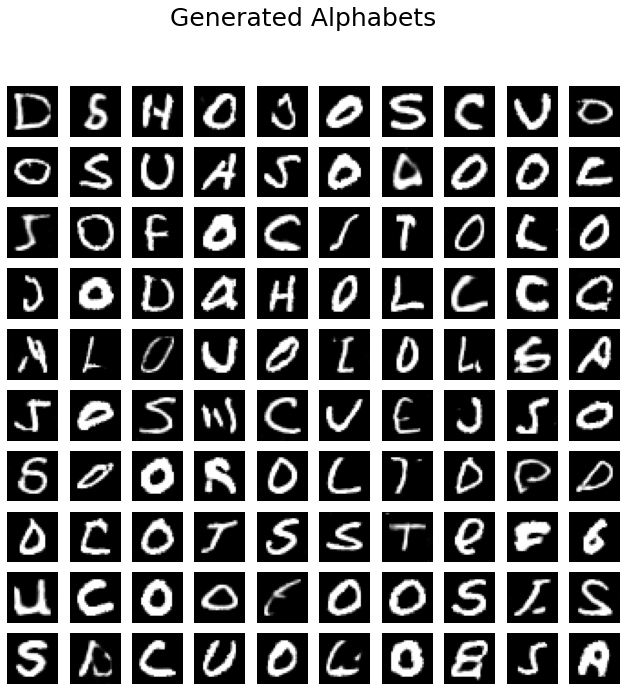

In [17]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = generator.predict(input_gen)
        
        real_data = X[np.random.randint(0, X.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, width, height, channel))
        
        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = gan.train_on_batch(input_gen, label_gen)

    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_generated_alphabets("Generated Alphabets", epoch)